<a href="https://colab.research.google.com/github/salmaaa9/Iris-Classification/blob/main/Iris_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

In [118]:
df = pd.read_csv("/content/iris - iris.csv")
df.head(10)


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


**preprocessing**

In [81]:
#Explore the datasets
def explore_dataset(dataframe):
    summary = []
    for column in dataframe.columns:
        data_type = dataframe[column].dtype
        total_count = len(dataframe[column])
        unique_count = dataframe[column].nunique()
        unique_sample = dataframe[column].unique()[0:10]
        missing_values = dataframe[column].isnull().sum()
        summary.append({'Column': column, 'Data Type': data_type, 'total count': total_count,
                        'Unique Count': unique_count, 'Unique Sample': unique_sample,
                        'Missing Values': missing_values})
    return pd.DataFrame(summary)

## Explore all dataset in one go-- make sure IDE displays maximum output with side scrolling.
datasets = [("Iris Dataset", df)]

for index, (dataset_name, dataset) in enumerate(datasets, start=1):
    print(f"{index}. Explore {dataset_name} dataset key details:")
    print(explore_dataset(dataset))
    print("\n")

1. Explore Iris Dataset dataset key details:
         Column Data Type  total count  Unique Count  \
0  sepal_length   float64          150            35   
1   sepal_width   float64          150            23   
2  petal_length   float64          150            43   
3   petal_width   float64          150            22   
4       species    object          150             3   

                                       Unique Sample  Missing Values  
0  [5.1, 4.9, 4.7, 4.6, 5.0, 5.4, 4.4, 4.8, 4.3, ...               0  
1  [3.5, 3.0, 3.2, 3.1, 3.6, 3.9, 3.4, 2.9, 3.7, ...               0  
2  [1.4, 1.3, 1.5, 1.7, 1.6, 1.1, 1.2, 1.0, 1.9, ...               0  
3  [0.2, 0.4, 0.3, 0.1, 0.5, 0.6, 1.4, 1.5, 1.3, ...               0  
4     [Iris-setosa, Iris-versicolor, Iris-virginica]               0  




In [68]:
#identity missing values and duplicates
def check_missing_and_duplicates(*datasets):
    for dataset_name, dataset in datasets:
        missing_values_count = {}
        duplicates_count = {}

        # Check missing values amd duplicates
        for column_name in dataset.columns:
            missing_count = dataset[column_name].isnull().sum()
            if missing_count > 0:
                missing_values_count[column_name] = missing_count

        duplicates = dataset[dataset.duplicated()]
        duplicates_count["total"] = len(duplicates)

          # Print summary
        print(f"Missing values and duplicates summary for {dataset_name}:")
        if len(missing_values_count) == 0:
            print("No missing values in this dataset.")
        else:
            print("Missing Values:")
            for column_name, count in missing_values_count.items():
                print(f" - Column: {column_name}, Missing Values Count: {count}")

        if duplicates_count["total"] == 0:
            print("No duplicates in this dataset.")
        else:
            print("Duplicates:")
            print(f" - Total duplicates: {duplicates_count['total']}")
        print()  # Add newline between each dataset summary

check_missing_and_duplicates(("Iris Dataset", df))

Missing values and duplicates summary for Iris Dataset:
No missing values in this dataset.
Duplicates:
 - Total duplicates: 3



In [119]:
df.drop_duplicates(inplace=True)

to check the that each thereis no one class that has most of the data

In [70]:
df['species'].value_counts()

,count
species,
Iris-versicolor,50
Iris-virginica,49
Iris-setosa,48


In [120]:
x,y = df.iloc[:,:-1],df.iloc[:,-1]
# Convert target variable to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

**Neural Network**

In [121]:
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 32)  # Input layer: 4 features
        self.fc2 = nn.Linear(32, 12) # Hidden layer
        self.fc3 = nn.Linear(12, 3)  # Output layer: 3 classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No softmax here because CrossEntropyLoss applies it internally
        return x


**Define Loss Function**

In [122]:
model = IrisNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


**train the model**

In [123]:
def train_model(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=400):
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Validation phase
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    return train_losses, test_losses

train_losses, test_losses = train_model(model, criterion, optimizer, X_train, y_train, X_test, y_test)


Epoch [10/400], Loss: 1.0418, Test Loss: 1.0487
Epoch [20/400], Loss: 1.0067, Test Loss: 1.0122
Epoch [30/400], Loss: 0.9692, Test Loss: 0.9724
Epoch [40/400], Loss: 0.9265, Test Loss: 0.9268
Epoch [50/400], Loss: 0.8778, Test Loss: 0.8740
Epoch [60/400], Loss: 0.8233, Test Loss: 0.8184
Epoch [70/400], Loss: 0.7619, Test Loss: 0.7563
Epoch [80/400], Loss: 0.6952, Test Loss: 0.6877
Epoch [90/400], Loss: 0.6243, Test Loss: 0.6149
Epoch [100/400], Loss: 0.5523, Test Loss: 0.5413
Epoch [110/400], Loss: 0.4834, Test Loss: 0.4717
Epoch [120/400], Loss: 0.4213, Test Loss: 0.4098
Epoch [130/400], Loss: 0.3685, Test Loss: 0.3583
Epoch [140/400], Loss: 0.3245, Test Loss: 0.3181
Epoch [150/400], Loss: 0.2875, Test Loss: 0.2865
Epoch [160/400], Loss: 0.2555, Test Loss: 0.2613
Epoch [170/400], Loss: 0.2272, Test Loss: 0.2404
Epoch [180/400], Loss: 0.2020, Test Loss: 0.2226
Epoch [190/400], Loss: 0.1799, Test Loss: 0.2074
Epoch [200/400], Loss: 0.1604, Test Loss: 0.1950
Epoch [210/400], Loss: 0.1433

**Evaluation: Accuracy, Confusion Matrix, Precision, Recall, F1-Score**

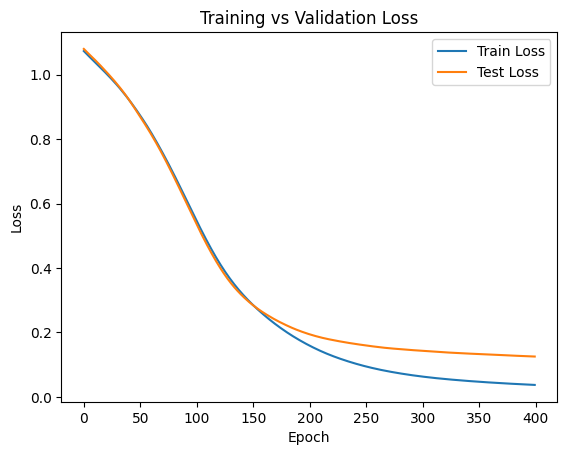

In [126]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [124]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predictions on test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    _, y_pred_labels = torch.max(y_pred, 1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)
print('\nConfusion Matrix:\n', cm)

# Classification report: Precision, Recall, F1-Score
report = classification_report(y_test, y_pred_labels)
print('\nClassification Report:\n', report)


Accuracy: 96.67%

Confusion Matrix:
 [[11  0  0]
 [ 0  9  1]
 [ 0  0  9]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.90      0.95        10
           2       0.90      1.00      0.95         9

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



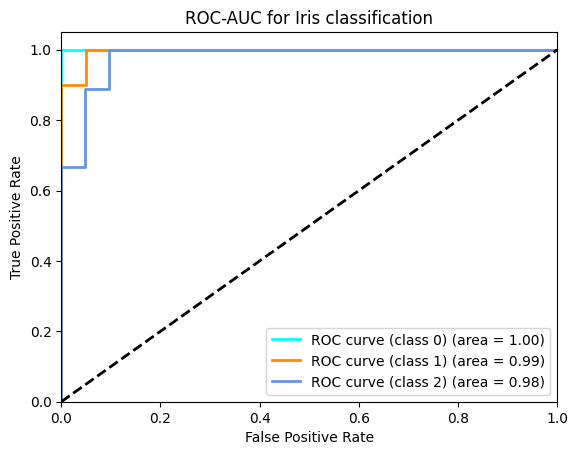

In [125]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Binarize the labels for ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# ROC curve and AUC calculation
y_score = model(X_test).detach().numpy()

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC for Iris classification')
plt.legend(loc='lower right')
plt.show()


no of false positives in the three classes is very small
and in clase 0 it's none 'Perfect classifier'